In [37]:
import os
import glob
import xarray as xr
import pandas as pd

def clip_and_convert_nc4_to_csv(input_folder, output_folder, lat_start, lat_end, lon_start, lon_end):
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_folder, exist_ok=True)
    
    # Lấy danh sách các tệp .nc4 trong thư mục đầu vào
    nc4_files = glob.glob(os.path.join(input_folder, '*.nc4'))
    
    for nc4_file in nc4_files:
        # Đọc tệp .nc4
        ds = xr.open_dataset(nc4_file)
        
        # Cắt dữ liệu theo tọa độ giới hạn
        ds_clipped = ds.sel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
        
        # Chuyển đổi dữ liệu thành DataFrame
        df = ds_clipped.to_dataframe().reset_index()
        
        # Tên tệp đầu ra
        output_file = os.path.join(output_folder, os.path.basename(nc4_file).replace('.nc4', '.csv'))
        
        # Lưu dữ liệu vào tệp CSV
        df.to_csv(output_file, index=False)
        
        print(f"Đã lưu tệp CSV: {output_file}")

def main():
    input_folder = r"D:\GPM"  # Đường dẫn thư mục chứa các tệp .nc4
    output_folder = r"D:\GPM_csv"  # Đường dẫn thư mục đầu ra
    
    # Tọa độ giới hạn của Việt Nam
    lat_start, lat_end = 8, 24
    lon_start, lon_end = 102, 110
    
    clip_and_convert_nc4_to_csv(input_folder, output_folder, lat_start, lat_end, lon_start, lon_end)

if __name__ == "__main__":
    main()

Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240101-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240102-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240103-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240104-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240105-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240106-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240107-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240108-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240109-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240110-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240111-S000000-E235959.V07B.csv
Đã lưu tệp CSV: D:\GPM_csv\3B-DAY-L.MS.MRG.3IMERG.20240112-S000000-E235959.V

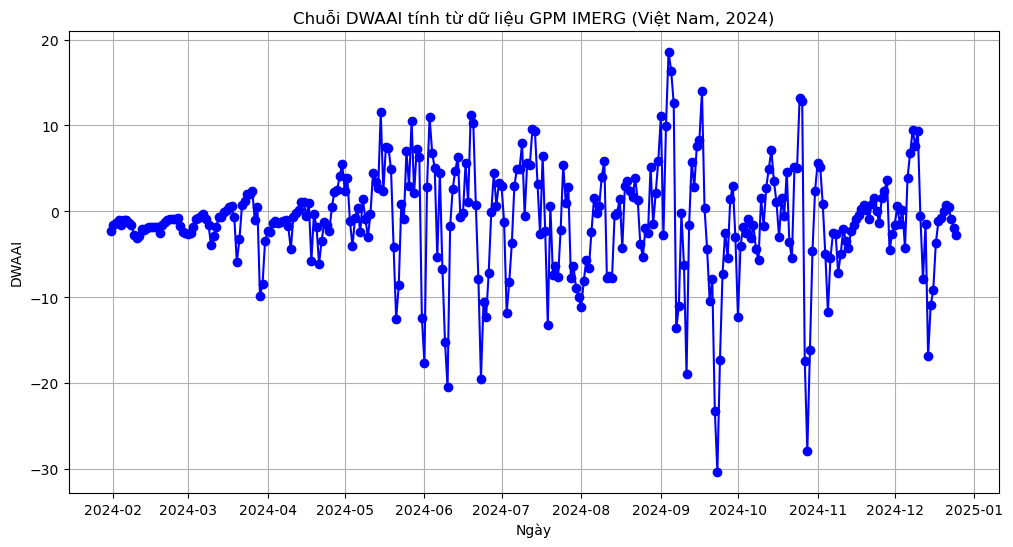

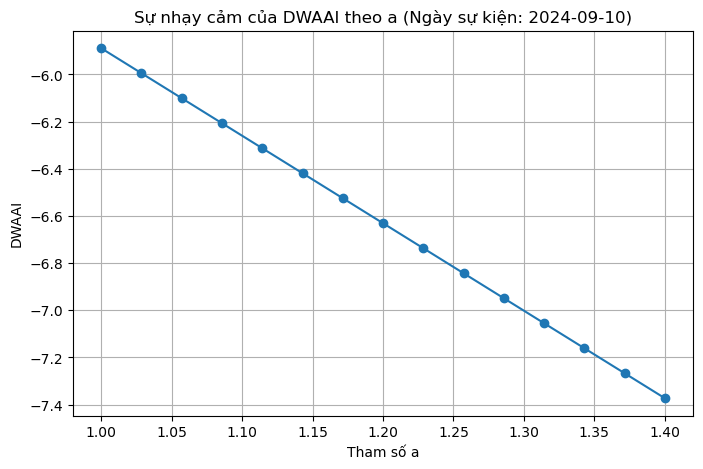

Kết quả DWAAI được lưu vào file D:\GPM_csv\DWAAI_Vietnam_2024_1.csv


In [67]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------
# 1. Đọc và kết hợp dữ liệu từ folder chứa các file CSV hàng ngày
# -------------------------
folder_path = "D:\\GPM_csv"  # Thay đổi đường dẫn đến folder chứa file CSV của bạn

# Lấy danh sách file có định dạng .csv
file_list = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Sử dụng regex để trích xuất ngày theo định dạng YYYYMMDD từ tên file
date_pattern = r"3IMERG\.(\d{8})-S"

df_list = []
for filename in file_list:
    match = re.search(date_pattern, filename)
    if match:
        date_str = match.group(1)
        file_date = datetime.strptime(date_str, "%Y%m%d")
        filepath = os.path.join(folder_path, filename)
        # Giả sử mỗi file CSV có cột "precip" chứa lượng mưa (mm)
        df_temp = pd.read_csv(filepath)
        df_temp["date"] = file_date
        df_list.append(df_temp)

# Ghép tất cả dữ liệu lại thành 1 DataFrame lớn
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    df_all.sort_values("date", inplace=True)
else:
    raise ValueError("Không tìm thấy file CSV phù hợp trong folder.")

# -------------------------
# 2. Xử lý dữ liệu: Gom nhóm theo ngày
# -------------------------
# Nếu mỗi file chứa nhiều hàng (ví dụ, theo pixel hoặc vùng) ta có thể lấy trung bình theo ngày.
# Nếu mỗi file đã là dữ liệu tổng hợp theo ngày, bước này có thể bỏ qua.
daily_df = df_all.groupby("date", as_index=False).agg({"precipitation": "mean"})

# -------------------------
# 3. Tính toán SPA (Standardized Precipitation Anomaly)
# -------------------------
# Tính trung bình và độ lệch chuẩn của lượng mưa theo toàn bộ khoảng thời gian
mean_precip = daily_df["precipitation"].mean()
std_precip = daily_df["precipitation"].std()

daily_df["SPA"] = (daily_df["precipitation"] - mean_precip) / std_precip

# -------------------------
# 4. Hàm tính DWAAI cho một ngày sự kiện
# -------------------------
def compute_dwAAI(event_day, dry_duration=30, wet_duration=7, a=1.1, df_precip=daily_df):
    """
    Tính chỉ số DWAAI cho một ngày sự kiện dựa trên:
      - dry_duration: số ngày của dry spell trước event_day (mặc định 30 ngày)
      - wet_duration: số ngày của wet spell sau event_day (mặc định 7 ngày)
      - a: tham số trọng số điều chỉnh "alternation degree" (mặc định 1.3)
    Công thức DWAAI:
      DWAAI = [K + (SPA_after - SPA_before) * (|SPA_before| + |SPA_after|)] * a - |SPA_before + SPA_after|
    trong đó:
      K = sum_{i=1}^{n} (SAPI_i - SAPI0),
      SAPI_i: SPA của ngày thứ i trong wet spell,
      SAPI0: SPA của ngày cuối của dry spell.
    df_precip: DataFrame chứa cột "date" (kiểu datetime) và "SPA".
    """
    # Lấy dry spell: dry_duration ngày trước event_day
    dry_mask = (df_precip["date"] >= event_day - timedelta(days=dry_duration)) & (df_precip["date"] < event_day)
    # Lấy wet spell: wet_duration ngày bắt đầu từ event_day
    wet_mask = (df_precip["date"] >= event_day) & (df_precip["date"] < event_day + timedelta(days=wet_duration))
    
    dry_period = df_precip.loc[dry_mask]
    wet_period = df_precip.loc[wet_mask]
    
    # Nếu không đủ số ngày, trả về NaN
    if len(dry_period) < dry_duration or len(wet_period) < wet_duration:
        return np.nan
    
    # Tính SPA trung bình của dry và wet spell
    SPA_before = dry_period["SPA"].mean()
    SPA_after  = wet_period["SPA"].mean()
    
    # Lấy SPA của ngày cuối dry spell
    SAPI0 = dry_period.iloc[-1]["SPA"]
    # Tính K: tổng chênh lệch giữa SPA của mỗi ngày trong wet spell và SAPI0
    K = (wet_period["SPA"] - SAPI0).sum()
    
    # Tính DWAAI theo công thức
    DWAAI = (K + (SPA_after - SPA_before) * (abs(SPA_before) + abs(SPA_after))) * a - abs(SPA_before + SPA_after)
    return DWAAI

# -------------------------
# 5. Tính DWAAI cho từng ngày trong khoảng thời gian có đủ dữ liệu cho dry và wet spell
# -------------------------
# Lấy danh sách ngày có đủ dữ liệu dry/wet
def has_enough_data(event_day, df_precip=daily_df, dry_duration=30, wet_duration=7):
    dry_mask = (df_precip["date"] >= event_day - timedelta(days=dry_duration)) & (df_precip["date"] < event_day)
    wet_mask = (df_precip["date"] >= event_day) & (df_precip["date"] < event_day + timedelta(days=wet_duration))
    return (len(df_precip.loc[dry_mask]) >= dry_duration) and (len(df_precip.loc[wet_mask]) >= wet_duration)

# Tính DWAAI cho mỗi ngày mà đủ dữ liệu
daily_df["DWAAI"] = daily_df["date"].apply(lambda d: compute_dwAAI(d, dry_duration=30, wet_duration=7, a=1.1)
                                           if has_enough_data(d, dry_duration=30, wet_duration=7) else np.nan)

# Vẽ chuỗi DWAAI theo thời gian
plt.figure(figsize=(12,6))
plt.plot(daily_df["date"], daily_df["DWAAI"], marker="o", linestyle="-", color="blue")
plt.xlabel("Ngày")
plt.ylabel("DWAAI")
plt.title("Chuỗi DWAAI tính từ dữ liệu GPM IMERG (Việt Nam, 2024)")
plt.grid(True)
plt.show()

# -------------------------
# 6. Khảo sát nhạy cảm của DWAAI theo tham số a cho một ngày sự kiện mẫu
# -------------------------
# Chọn một ngày sự kiện mẫu (ví dụ: 15/09/2024)
event_day = datetime(2024, 9, 10)
a_candidates = np.linspace(1.0, 1.4, 15)
dwAAI_values = [compute_dwAAI(event_day, dry_duration=30, wet_duration=7, a=a_val) for a_val in a_candidates]

plt.figure(figsize=(8,5))
plt.plot(a_candidates, dwAAI_values, marker="o", linestyle="-")
plt.xlabel("Tham số a")
plt.ylabel("DWAAI")
plt.title(f"Sự nhạy cảm của DWAAI theo a (Ngày sự kiện: {event_day.date()})")
plt.grid(True)
plt.show()

# -------------------------
# 7. (Tuỳ chọn) Xuất kết quả DWAAI ra file CSV
# -------------------------
output_csv = "D:\\GPM_csv\\DWAAI_Vietnam_2024_1.csv"
daily_df.to_csv(output_csv, index=False)
print(f"Kết quả DWAAI được lưu vào file {output_csv}")



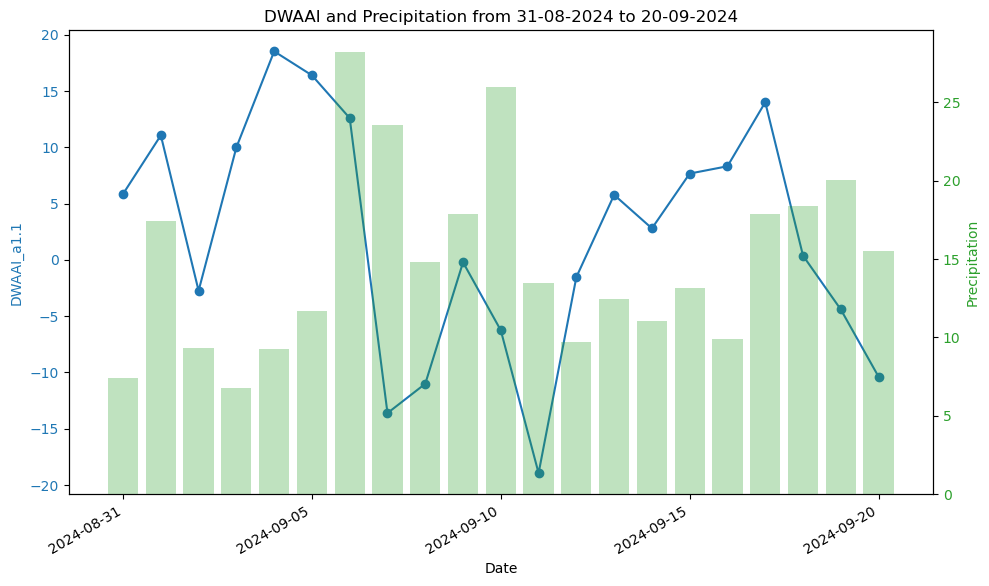

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_dwaai_precipitation(csv_file, start_date, end_date):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(csv_file)
    
    # Lọc dữ liệu theo khoảng thời gian từ 31-08-2024 đến 20-09-2024
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    df_filtered = df.loc[mask]
    
    # Vẽ biểu đồ
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DWAAI_a1.1', color=color)
    ax1.plot(df_filtered['date'], df_filtered['DWAAI_a1.1'], color=color, marker='o', label='DWAAI_a1.1')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('Precipitation', color=color)  # we already handled the x-label with ax1
    ax2.bar(df_filtered['date'], df_filtered['precipitation'], color=color, alpha=0.3, label='Precipitation')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('DWAAI and Precipitation from 31-08-2024 to 20-09-2024')
    
    # Hiển thị cột ngày theo định dạng ngắn gọn
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=5))  # Hiển thị tối đa 5 cột ngày
    plt.gcf().autofmt_xdate()  # Tự động định dạng lại các cột ngày

    plt.show()

def main():
    csv_file = r"D:\GPM_csv\results\DWAAI_Vietnam_2024_a1.1.csv"  # Đường dẫn tệp CSV
    start_date = '2024-08-31'
    end_date = '2024-09-20'
    
    plot_dwaai_precipitation(csv_file, start_date, end_date)

if __name__ == "__main__":
    main()

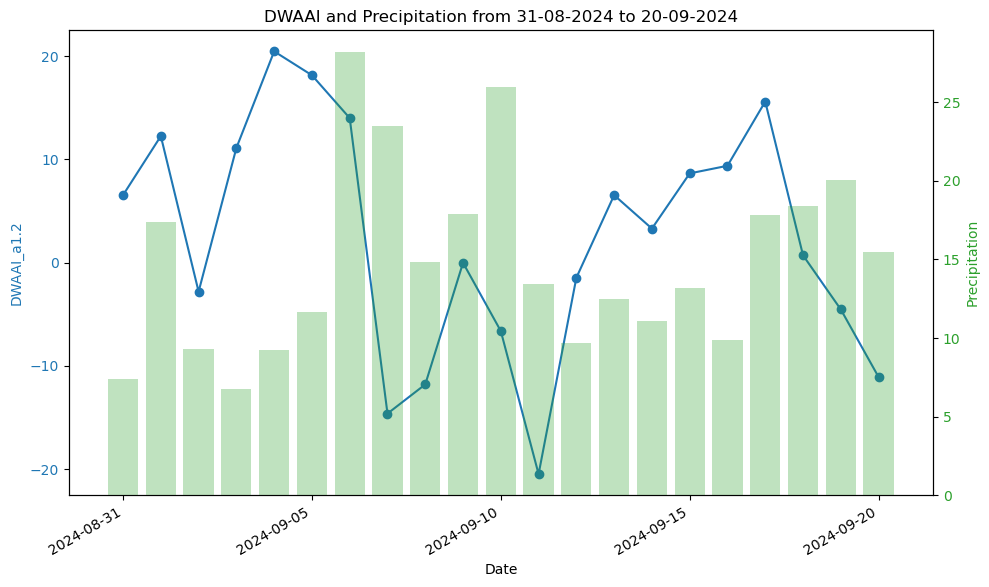

Đã lưu kết quả DWAAI với a = 1.1 vào file D:\GPM_csv\results\DWAAI_Vietnam_2024_a1.1.csv
Đã lưu kết quả DWAAI với a = 1.2 vào file D:\GPM_csv\results\DWAAI_Vietnam_2024_a1.2.csv
Đã lưu kết quả DWAAI với a = 1.3 vào file D:\GPM_csv\results\DWAAI_Vietnam_2024_a1.3.csv
Đã lưu kết quả DWAAI với a = 1.4 vào file D:\GPM_csv\results\DWAAI_Vietnam_2024_a1.4.csv


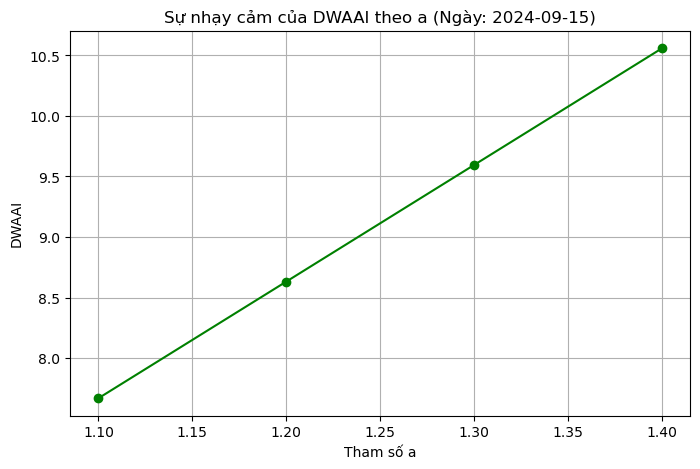

In [73]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------
# 1. Đọc dữ liệu từ folder chứa các file CSV của GPM IMERG
# -------------------------
folder_path = r"D:\GPM_csv"  # Thay đổi đường dẫn đến folder của bạn
file_list = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Regex để trích xuất ngày từ tên file theo định dạng "3IMERG.YYYYMMDD-S..."
date_pattern = r"3IMERG\.(\d{8})-S"
df_list = []
for filename in file_list:
    match = re.search(date_pattern, filename)
    if match:
        date_str = match.group(1)
        file_date = datetime.strptime(date_str, "%Y%m%d")
        filepath = os.path.join(folder_path, filename)
        # Giả sử file CSV có cột "precip" chứa lượng mưa (mm)
        df_temp = pd.read_csv(filepath)
        df_temp["date"] = file_date
        df_list.append(df_temp)

if not df_list:
    raise ValueError("Không tìm thấy file CSV phù hợp trong folder.")

# Ghép tất cả dữ liệu lại và sắp xếp theo ngày
df_all = pd.concat(df_list, ignore_index=True)
df_all.sort_values("date", inplace=True)

# -------------------------
# 2. Gom nhóm theo ngày và tính trung bình lượng mưa
# -------------------------
daily_df = df_all.groupby("date", as_index=False).agg({"precipitation": "mean"})

# -------------------------
# 3. Tính SPA (Standardized Precipitation Anomaly)
# -------------------------
mean_precip = daily_df["precipitation"].mean()
std_precip = daily_df["precipitation"].std()
daily_df["SPA"] = (daily_df["precipitation"] - mean_precip) / std_precip

# -------------------------
# 4. Hàm tính DWAAI cho một ngày sự kiện
# -------------------------
def compute_dwAAI(event_day, dry_duration=30, wet_duration=7, a=1.3, df_precip=daily_df):
    """
    Tính DWAAI cho một ngày event_day dựa trên dry spell và wet spell.
    
    dry_duration: số ngày dry spell trước event_day (mặc định 30 ngày)
    wet_duration: số ngày wet spell sau event_day (mặc định 7 ngày)
    a: tham số trọng số (giá trị ứng viên)
    
    Công thức DWAAI:
      DWAAI = [K + (SPA_after - SPA_before)*(|SPA_before|+|SPA_after|)]*a - |SPA_before+SPA_after|
      
    Trong đó:
      - SPA_before: trung bình SPA của dry spell.
      - SPA_after: trung bình SPA của wet spell.
      - SAPI0: SPA của ngày cuối của dry spell.
      - K = Σ (SPA của wet spell - SAPI0) cho các ngày wet spell.
    """
    # Xác định dry spell và wet spell
    dry_mask = (df_precip["date"] >= event_day - timedelta(days=dry_duration)) & (df_precip["date"] < event_day)
    wet_mask = (df_precip["date"] >= event_day) & (df_precip["date"] < event_day + timedelta(days=wet_duration))
    
    dry_period = df_precip.loc[dry_mask]
    wet_period = df_precip.loc[wet_mask]
    
    # Nếu số ngày không đủ, trả về NaN
    if len(dry_period) < dry_duration or len(wet_period) < wet_duration:
        return np.nan
    
    SPA_before = dry_period["SPA"].mean()
    SPA_after  = wet_period["SPA"].mean()
    SAPI0 = dry_period.iloc[-1]["SPA"]
    K = (wet_period["SPA"] - SAPI0).sum()
    
    DWAAI = (K + (SPA_after - SPA_before) * (abs(SPA_before) + abs(SPA_after))) * a - abs(SPA_before + SPA_after)
    return DWAAI

# -------------------------
# 5. Tính DWAAI cho từng giá trị của a và lưu kết quả ra file CSV
# -------------------------
# Danh sách các giá trị a ứng viên
a_candidates = [1.1, 1.2, 1.3, 1.4]

# Tạo thư mục output nếu chưa có
output_folder = r"D:\GPM_csv\results"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Để tính DWAAI cho mỗi ngày đủ dữ liệu dry/wet, chúng ta cần xác định các ngày đó.
def has_enough_data(event_day, df_precip=daily_df, dry_duration=30, wet_duration=7):
    dry_mask = (df_precip["date"] >= event_day - timedelta(days=dry_duration)) & (df_precip["date"] < event_day)
    wet_mask = (df_precip["date"] >= event_day) & (df_precip["date"] < event_day + timedelta(days=wet_duration))
    return (len(df_precip.loc[dry_mask]) >= dry_duration) and (len(df_precip.loc[wet_mask]) >= wet_duration)

# Copy DataFrame gốc để thêm cột DWAAI cho từng giá trị a
df_out = daily_df.copy()

# Với mỗi giá trị a, tính DWAAI cho mỗi ngày và lưu ra file CSV riêng
for a_val in a_candidates:
    col_name = f"DWAAI_a{a_val}"
    # Tính chỉ số DWAAI chỉ cho những ngày có đủ dữ liệu
    df_out[col_name] = df_out["date"].apply(lambda d: compute_dwAAI(d, dry_duration=30, wet_duration=7, a=a_val)
                                           if has_enough_data(d, dry_duration=30, wet_duration=7) else np.nan)
    # Xuất ra file CSV cho giá trị a này
    output_csv = os.path.join(output_folder, f"DWAAI_Vietnam_2024_a{a_val}.csv")
    df_out[["date", "precipitation", "SPA", col_name]].to_csv(output_csv, index=False)
    print(f"Đã lưu kết quả DWAAI với a = {a_val} vào file {output_csv}")

# -------------------------
# 6. (Tuỳ chọn) Vẽ biểu đồ để khảo sát DWAAI theo a cho một ngày sự kiện mẫu
# -------------------------
event_day = datetime(2024, 9, 15)
dwAAI_vals = [compute_dwAAI(event_day, dry_duration=30, wet_duration=7, a=a_val) for a_val in a_candidates]

plt.figure(figsize=(8,5))
plt.plot(a_candidates, dwAAI_vals, marker="o", linestyle="-", color="green")
plt.xlabel("Tham số a")
plt.ylabel("DWAAI")
plt.title(f"Sự nhạy cảm của DWAAI theo a (Ngày: {event_day.date()})")
plt.grid(True)
plt.show()
